In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
np.set_printoptions(precision=3)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Read Dataset

In [3]:
def read_txt(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, sep=';', header=None, names=['sentence', 'label'])
    df['label'] = df['label'].astype('category').cat.codes
    return df

train_df = read_txt('/content/train.txt')
valid_df = read_txt('/content/val.txt')
test_df  = read_txt('/content/test.txt')

label_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['label']),  y=train_df['label'])

Plot class distribution

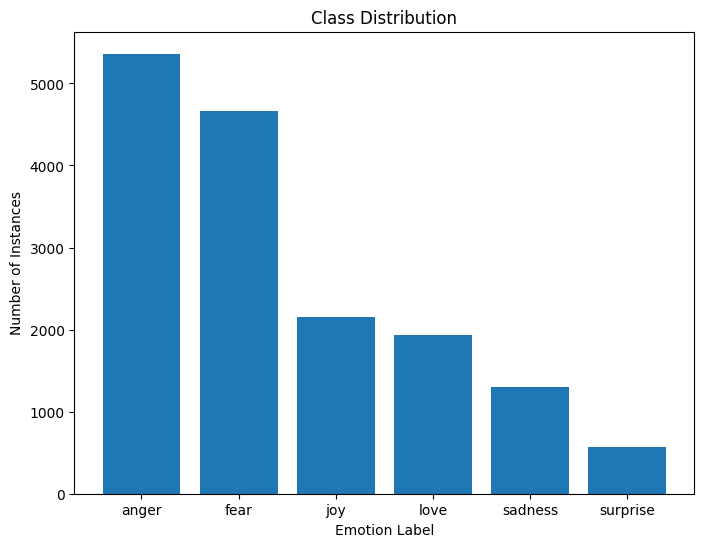

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each label in the dataset
label_counts = train_df['label'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(label_names, label_counts)
plt.xlabel('Emotion Label')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()


validation test


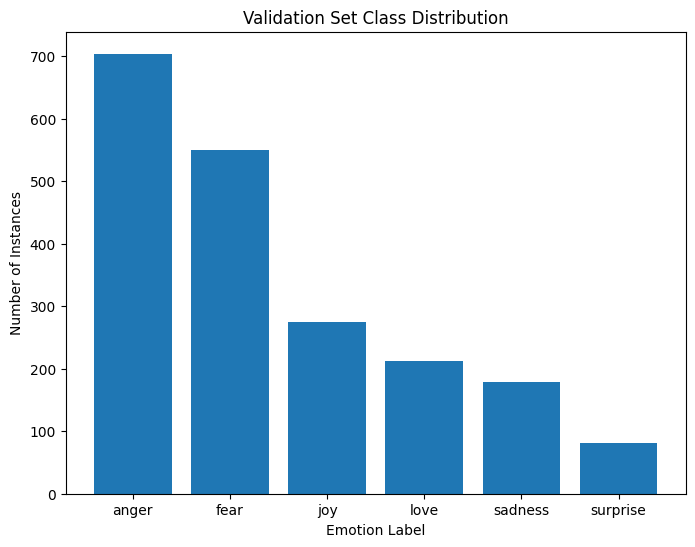

In [5]:
import matplotlib.pyplot as plt

# Count the occurrences of each label in the validation dataset
label_counts_valid = valid_df['label'].value_counts()

# Plot the class distribution for the validation set
plt.figure(figsize=(8, 6))
plt.bar(label_names, label_counts_valid)
plt.xlabel('Emotion Label')
plt.ylabel('Number of Instances')
plt.title('Validation Set Class Distribution')
plt.show()


test set

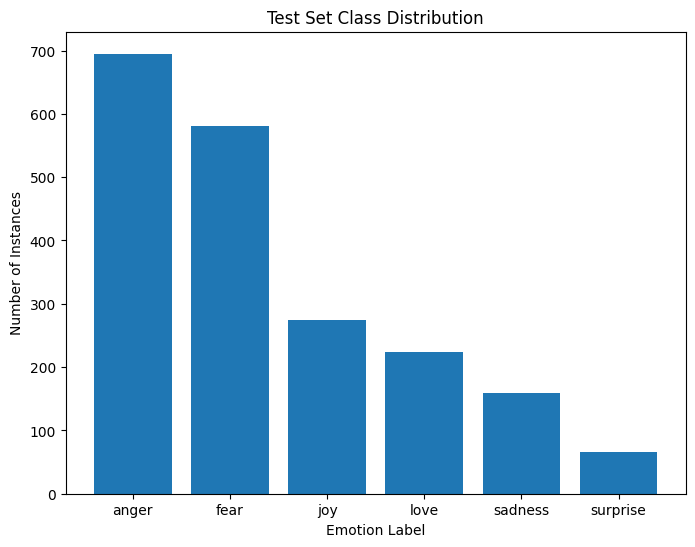

In [6]:
import matplotlib.pyplot as plt

# Count the occurrences of each label in the test dataset
label_counts_test = test_df['label'].value_counts()

# Plot the class distribution for the test set
plt.figure(figsize=(8, 6))
plt.bar(label_names, label_counts_test)
plt.xlabel('Emotion Label')
plt.ylabel('Number of Instances')
plt.title('Test Set Class Distribution')
plt.show()


Data Preprocessing:

Tokenization:

Tokenization involves splitting text into individual words or tokens. You can use libraries like NLTK or spaCy for tokenization.

In [7]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

# Tokenize the sentences
train_df['tokens'] = train_df['sentence'].apply(word_tokenize)
valid_df['tokens'] = valid_df['sentence'].apply(word_tokenize)
test_df['tokens'] = test_df['sentence'].apply(word_tokenize)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Lowercasing:
Convert all words to lowercase to ensure consistency.

In [8]:
# Convert tokens to lowercase
train_df['tokens'] = train_df['tokens'].apply(lambda x: [token.lower() for token in x])
valid_df['tokens'] = valid_df['tokens'].apply(lambda x: [token.lower() for token in x])
test_df['tokens'] = test_df['tokens'].apply(lambda x: [token.lower() for token in x])


Removing Stopwords:
Remove common words like "the", "is", "and", etc., that don't carry much meaning.

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Remove stopwords
train_df['tokens'] = train_df['tokens'].apply(lambda x: [token for token in x if token not in stop_words])
valid_df['tokens'] = valid_df['tokens'].apply(lambda x: [token for token in x if token not in stop_words])
test_df['tokens'] = test_df['tokens'].apply(lambda x: [token for token in x if token not in stop_words])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stemming or Lemmatization (Optional):
Reduce words to their base or root form. This step can help reduce the dimensionality of the feature space.

In [10]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Lemmatize tokens
train_df['tokens'] = train_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
valid_df['tokens'] = valid_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
test_df['tokens'] = test_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Vectorization:
Convert tokens into numerical vectors using techniques like Bag of Words (BoW), TF-IDF, or word embeddings.

Bag of Words (BoW):

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_bow = count_vectorizer.fit_transform(train_df['sentence'])

# Transform the validation and test data
X_valid_bow = count_vectorizer.transform(valid_df['sentence'])
X_test_bow = count_vectorizer.transform(test_df['sentence'])


TF-IDF (Term Frequency-Inverse Document Frequency):

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['sentence'])

# Transform the validation and test data
X_valid_tfidf = tfidf_vectorizer.transform(valid_df['sentence'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['sentence'])


In [13]:
#Instantiate the Model:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
model = LogisticRegression()


In [14]:
# Assuming X_train_tfidf is the TF-IDF vectorized features and train_df['label'] contains the corresponding labels
model.fit(X_train_tfidf, train_df['label'])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
# Assuming X_valid_tfidf is the TF-IDF vectorized features of the validation set
predictions = model.predict(X_valid_tfidf)


In [16]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(valid_df['label'], predictions)
print("Validation Accuracy:", accuracy)

# Print classification report
print(classification_report(valid_df['label'], predictions))


Validation Accuracy: 0.8595
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       275
           1       0.86      0.73      0.79       212
           2       0.84      0.95      0.89       704
           3       0.89      0.61      0.72       178
           4       0.86      0.94      0.90       550
           5       0.85      0.58      0.69        81

    accuracy                           0.86      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.86      0.86      0.85      2000



In [17]:
# Example of hyperparameter tuning
model_tuned = LogisticRegression(C=0.1)  # Adjust the value of C as needed
model_tuned.fit(X_train_tfidf, train_df['label'])


LogisticRegression(C=0.1)

In [18]:
predictions_tuned = model_tuned.predict(X_valid_tfidf)
accuracy_tuned = accuracy_score(valid_df['label'], predictions_tuned)
print("Tuned Model Validation Accuracy:", accuracy_tuned)


Tuned Model Validation Accuracy: 0.6265


using the sklearn pipeline module create a classification pipeline to classify the Data.
use CountVectorizer with both unigram and Bigrams.
use  as the classifier.
print the classification report.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),  # Use both unigrams and bigrams
    ('classifier', LogisticRegression())                # Logistic Regression as the classifier
])

# Fit the pipeline on the training data
pipeline.fit(train_df['sentence'], train_df['label'])

# Predict labels for the validation set
valid_preds = pipeline.predict(valid_df['sentence'])

# Print the classification report
print(classification_report(valid_df['label'], valid_preds, target_names=label_names))


              precision    recall  f1-score   support

       anger       0.91      0.89      0.90       275
        fear       0.90      0.77      0.83       212
         joy       0.89      0.94      0.92       704
        love       0.85      0.72      0.78       178
     sadness       0.89      0.94      0.91       550
    surprise       0.80      0.69      0.74        81

    accuracy                           0.89      2000
   macro avg       0.87      0.83      0.85      2000
weighted avg       0.89      0.89      0.88      2000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


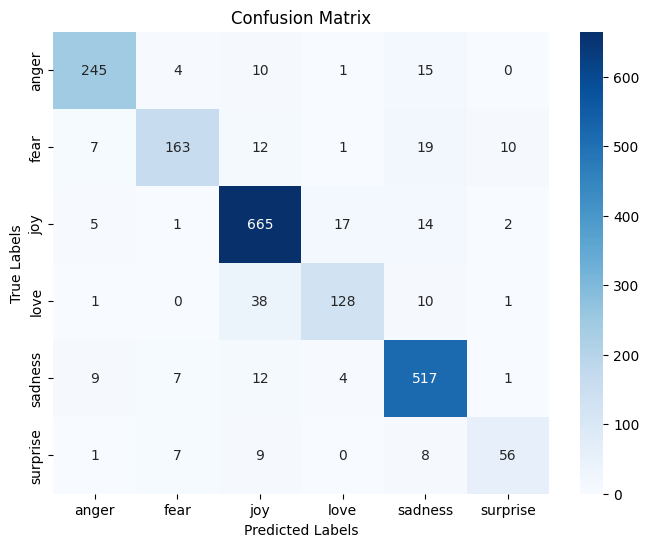

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(valid_df['label'], valid_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


:using the sklearn pipeline module create a classification pipeline to classify the Data.
use  for Pre-processing the text.
use  as the classifier.
print the classification report.

In [21]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [22]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

class NLTKPreprocessor(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_X = []
        for text in X:
            tokens = word_tokenize(text.lower())
            filtered_tokens = [token for token in tokens if token not in self.stop_words]
            lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in filtered_tokens]
            preprocessed_X.append(' '.join(lemmatized_tokens))
        return preprocessed_X

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', NLTKPreprocessor()),       # NLTKPreprocessor for text pre-processing
    ('vectorizer', CountVectorizer()),          # CountVectorizer for feature extraction
    ('classifier', LogisticRegression())        # Logistic Regression as the classifier
])

In [24]:
# Fit the pipeline on the training data
pipeline.fit(train_df['sentence'], train_df['label'])

# Predict labels for the validation set
valid_preds = pipeline.predict(valid_df['sentence'])

# Print the classification report
print(classification_report(valid_df['label'], valid_preds, target_names=label_names))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       anger       0.91      0.90      0.90       275
        fear       0.86      0.81      0.83       212
         joy       0.92      0.92      0.92       704
        love       0.81      0.81      0.81       178
     sadness       0.91      0.94      0.93       550
    surprise       0.79      0.73      0.76        81

    accuracy                           0.89      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.89      0.89      0.89      2000



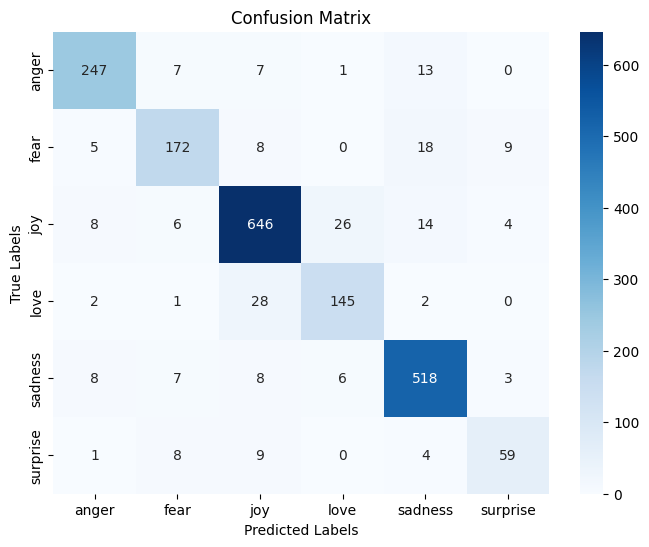

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(valid_df['label'], valid_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
